In [1]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import utils
import numpy as np
import torch.nn as nn
import os
import pandas as pd
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
writer = SummaryWriter("runs/STRATIFIED IMG-ONLY")

myseed = 0
torch.manual_seed(myseed)
np.random.seed(myseed)
generator=torch.Generator()
generator.manual_seed(myseed)

%matplotlib inline

2023-01-09 18:29:43.347009: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [3]:
data_path = "./"

In [4]:
images = os.listdir(f"{data_path}DATASET")
print(images)

['P_2_62.png', 'P_232.png', 'P_720.png', 'P_3_416.png', 'P_2_67.png', 'P_2_9.png', 'P_98.png', 'P_759.png', 'P_667.png', 'P_2_19.png', 'P_3_463.png', 'P_3_274.png', 'P_795.png', 'P_619.png', 'P_289.png', 'P_3_306.png', 'P_493.png', 'P_486.png', 'P_1_154.png', 'P_3_5.png', 'P_2_88.png', 'P_3_204.png', 'P_412.png', 'P_1_112.png', 'P_3_273.png', 'P_460.png', 'P_130.png', 'P_654.png', 'P_405.png', 'P_3_290.png', 'P_3_396.png', 'P_3_180.png', 'P_3_115.png', 'P_3_17.png', 'P_45.png', 'P_782.png', 'P_827.png', 'P_1_107.png', 'P_753.png', 'P_786.png', 'P_507.png', 'P_3_103.png', 'P_719.png', 'P_497.png', 'P_310.png', 'P_743.png', 'P_446.png', 'P_3_342.png', 'P_3_421.png', 'P_13.png', 'P_382.png', 'P_1_8.png', 'P_2_93.png', 'P_3_410.png', 'P_442.png', 'P_2_70.png', 'P_559.png', 'P_19.png', 'P_245.png', 'P_2.png', 'P_42.png', 'P_3_500.png', 'P_3_409.png', 'P_3_203.png', 'P_3_297.png', 'P_1_143.png', 'P_3_21.png', 'P_328.png', 'P_3_359.png', 'P_3_83.png', 'P_2_27.png', 'P_2_102.png', 'P_3_134.png

In [5]:
len(images)

1589

In [6]:
df = pd.read_excel("trainANDtest.xls")

In [7]:
df

,Unnamed: 0,Row_number,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,...,pH,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Prognosis,Death
0,0,82.0,P_102.png,1,72,1,1,37.3,3,1,...,7.46,0,0,0,0,1,0,0,1,0
1,1,228.0,P_131.png,4,35,0,1,39.3,3,1,...,7.46,1,0,0,0,0,0,0,0,0
2,2,229.0,P_132.png,4,57,0,1,37.0,3,0,...,7.42,0,0,0,0,0,0,0,0,0
3,3,96.0,P_117.png,1,39,1,1,37.2,2,1,...,7.38,0,0,0,0,0,0,0,0,0
4,4,112.0,P_16.png,1,44,0,1,38.0,3,1,...,7.47,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,481,1474.0,P_3_432.png,6,84,1,1,37.0,2,0,...,7.46,1,0,1,0,0,0,0,0,0
1585,482,1228.0,P_3_105.png,6,51,0,1,38.0,3,0,...,7.44,0,1,0,0,0,0,0,1,0
1586,483,1466.0,P_3_233.png,6,70,1,1,36.4,2,1,...,7.50,1,0,0,0,0,0,0,0,0
1587,484,1210.0,P_3_414.png,6,90,0,1,36.2,4,0,...,7.42,0,1,0,0,0,0,0,0,0


In [8]:
del df["Row_number"]
del df["Unnamed: 0"]

In [9]:
print("The total number of patients is", len(df))

The total number of patients is 1589


In [10]:
print("Classes are:")
print(df["Prognosis"].value_counts())

Classes are:
0    841
1    748
Name: Prognosis, dtype: int64


In [11]:
df.columns

Index(['ImageFile', 'Hospital', 'Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure', 'Prognosis', 'Death'],
      dtype='object')

In [12]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, indices, image_dir, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.indices.iloc[idx, 0:]

        y = tabular["Prognosis"]

        image = PIL.Image.open(f"{self.image_dir}/{tabular['ImageFile']}")
        image = image.convert('L')
        image = np.array(image)
        #image = image[..., :3]

        image = transforms.functional.to_tensor(image)

        tabular = tabular[['Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure']]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)
        
        if self.transform:
            image = self.transform(image)

        return image, tabular, y
    

In [13]:
from torchvision import transforms as T
my_transform = T.Compose([T.Resize((256,256)),
                          T.RandomApply(
                            [T.RandomHorizontalFlip(),
                             T.RandomCrop(256, padding=4)],
                            p=.5
                          )])

In [14]:
from sklearn.model_selection import train_test_split

tv_idx, test_idx = train_test_split(np.arange(len(df["Prognosis"])), test_size=0.2, shuffle=True, stratify=df["Prognosis"])

In [15]:
train_val_df = df.iloc[tv_idx]
train_val = ImageDataset(indices=train_val_df, image_dir=f"{data_path}DATASET", transform=my_transform)

In [16]:
len(train_val)

1271

In [17]:
test_df = df.iloc[test_idx]
test_set = ImageDataset(indices=test_df, image_dir=f"{data_path}DATASET", transform=my_transform)

len(test_set)

318

In [18]:
i = 3
print(f"{train_val[i][0].size()}, label = {train_val[i][1]}")

torch.Size([1, 256, 256]), label = tensor([ 73.0000,   1.0000,   1.0000,  37.4000,   2.0000,   1.0000,   0.0000,
          4.2000,   4.6500,   1.9200, 134.0000, 223.0000,   0.9600,  73.0000,
         31.0000,   7.4400,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000])


In [19]:
torch.cuda.is_available()

True

In [20]:
dev = torch.device('cuda')
print(dev)

cuda


# 1. SOLO IMMAGINI

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
               
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        torch.manual_seed(myseed)
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

model = ResNet18(1,1)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [22]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)


In [23]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param = False, model_name="only-images"):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, tabular, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)
            
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [24]:
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [25]:
test_loader  = DataLoader(test_set,  batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)

In [26]:
tv_labels = train_val_df['Prognosis'].tolist()

------------fold no---------0----------------------
Total samples in hospital A: 99
Total samples in hospital B: 76
Total samples in hospital C: 120
Total samples in hospital D: 115
Total samples in hospital E: 66
Total samples in hospital F: 540


/home/lmancuso/anaconda3/envs/openfl/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1: TrL=0.7099, TrA=0.5098, VL=0.6940, VA=0.5218, TeL=0.6989, TeA=0.4865, LR=0.00040,
Epoch 2: TrL=0.6995, TrA=0.4951, VL=0.7424, VA=0.5095, TeL=0.7182, TeA=0.5146, LR=0.00040,
Epoch 3: TrL=0.6976, TrA=0.4921, VL=0.7001, VA=0.4978, TeL=0.6951, TeA=0.5323, LR=0.00041,
Epoch 8: TrL=0.6974, TrA=0.5079, VL=0.7093, VA=0.5061, TeL=0.7260, TeA=0.4750, LR=0.00045,
Epoch 9: TrL=0.6949, TrA=0.4961, VL=0.7473, VA=0.5022, TeL=0.7297, TeA=0.5219, LR=0.00046,
Epoch 10: TrL=0.6944, TrA=0.5177, VL=0.7228, VA=0.5056, TeL=0.7070, TeA=0.5292, LR=0.00048,
Epoch 11: TrL=0.6962, TrA=0.5226, VL=0.7142, VA=0.5134, TeL=0.7384, TeA=0.4750, LR=0.00049,
Epoch 12: TrL=0.6927, TrA=0.4931, VL=0.7132, VA=0.4900, TeL=0.6988, TeA=0.5250, LR=0.00051,
Epoch 13: TrL=0.6916, TrA=0.5226, VL=0.7508, VA=0.5173, TeL=0.7247, TeA=0.5260, LR=0.00053,
Epoch 14: TrL=0.6965, TrA=0.5128, VL=0.8054, VA=0.5095, TeL=0.8569, TeA=0.4750, LR=0.00055,
Epoch 15: TrL=0.6970, TrA=0.4892, VL=0.7335, VA=0.5179, TeL=0.7144, TeA=0.5260, LR=0.

Epoch 99: TrL=0.6932, TrA=0.5207, VL=0.7019, VA=0.5173, TeL=0.6984, TeA=0.4969, LR=0.00620,
Epoch 100: TrL=0.6908, TrA=0.5197, VL=0.6905, VA=0.5056, TeL=0.6914, TeA=0.5437, LR=0.00628,
Epoch 101: TrL=0.6874, TrA=0.5098, VL=0.6998, VA=0.5480, TeL=0.6999, TeA=0.4844, LR=0.00637,
Epoch 102: TrL=0.6914, TrA=0.5148, VL=0.7054, VA=0.4581, TeL=0.6991, TeA=0.4688, LR=0.00645,
Epoch 103: TrL=0.6939, TrA=0.5079, VL=0.6950, VA=0.5022, TeL=0.6907, TeA=0.5344, LR=0.00653,
Epoch 104: TrL=0.6916, TrA=0.5039, VL=0.7164, VA=0.4944, TeL=0.6888, TeA=0.5406, LR=0.00662,
Epoch 105: TrL=0.6899, TrA=0.5305, VL=0.7050, VA=0.4821, TeL=0.6896, TeA=0.5375, LR=0.00670,
Epoch 106: TrL=0.6901, TrA=0.5226, VL=0.7305, VA=0.4604, TeL=0.7112, TeA=0.5437, LR=0.00678,
Epoch 107: TrL=0.6904, TrA=0.5000, VL=0.7009, VA=0.4916, TeL=0.6914, TeA=0.5250, LR=0.00686,
Epoch 108: TrL=0.6890, TrA=0.4970, VL=0.6955, VA=0.5251, TeL=0.6942, TeA=0.4990, LR=0.00694,
Epoch 109: TrL=0.6873, TrA=0.5472, VL=0.7057, VA=0.5296, TeL=0.6922, Te

Epoch 188: TrL=0.6705, TrA=0.5364, VL=1.1537, VA=0.5218, TeL=0.7869, TeA=0.5198, LR=0.00997,
Epoch 189: TrL=0.6795, TrA=0.5197, VL=0.7419, VA=0.5525, TeL=0.7000, TeA=0.4875, LR=0.00997,
Epoch 190: TrL=0.6847, TrA=0.5226, VL=0.9859, VA=0.5212, TeL=0.7463, TeA=0.4833, LR=0.00997,
Epoch 191: TrL=0.6737, TrA=0.5098, VL=0.7603, VA=0.5251, TeL=0.7039, TeA=0.4802, LR=0.00996,
Epoch 192: TrL=0.6757, TrA=0.5394, VL=0.8093, VA=0.5212, TeL=0.7328, TeA=0.4906, LR=0.00996,
Epoch 193: TrL=0.6838, TrA=0.5157, VL=0.7576, VA=0.4743, TeL=0.6945, TeA=0.5219, LR=0.00995,
Epoch 194: TrL=0.6772, TrA=0.5128, VL=0.8263, VA=0.4581, TeL=0.7026, TeA=0.5354, LR=0.00994,
Epoch 195: TrL=0.6705, TrA=0.5305, VL=0.8609, VA=0.4671, TeL=0.7501, TeA=0.5260, LR=0.00994,
Epoch 196: TrL=0.6771, TrA=0.5276, VL=0.7209, VA=0.4743, TeL=0.6963, TeA=0.5385, LR=0.00993,
Epoch 197: TrL=0.6685, TrA=0.5344, VL=0.8405, VA=0.4632, TeL=0.6981, TeA=0.5510, LR=0.00993,
Epoch 198: TrL=0.6778, TrA=0.5305, VL=0.8668, VA=0.4749, TeL=0.6881, T

Epoch 277: TrL=0.6391, TrA=0.5482, VL=0.7645, VA=0.5100, TeL=0.6835, TeA=0.5281, LR=0.00853,
Epoch 278: TrL=0.6490, TrA=0.5502, VL=0.8830, VA=0.4855, TeL=0.7384, TeA=0.5323, LR=0.00850,
Epoch 279: TrL=0.6476, TrA=0.5482, VL=1.0026, VA=0.5134, TeL=0.7095, TeA=0.4656, LR=0.00847,
Epoch 280: TrL=0.6420, TrA=0.5315, VL=0.9522, VA=0.4710, TeL=0.7027, TeA=0.5260, LR=0.00845,
Epoch 281: TrL=0.6450, TrA=0.5492, VL=0.8938, VA=0.4676, TeL=0.6967, TeA=0.5573, LR=0.00842,
Epoch 282: TrL=0.6422, TrA=0.5630, VL=0.8450, VA=0.4782, TeL=0.6914, TeA=0.5406, LR=0.00839,
Epoch 283: TrL=0.6471, TrA=0.5443, VL=0.8376, VA=0.4743, TeL=0.7018, TeA=0.5417, LR=0.00836,
Epoch 284: TrL=0.6511, TrA=0.5659, VL=0.8565, VA=0.4626, TeL=0.6987, TeA=0.5458, LR=0.00833,
Epoch 285: TrL=0.6448, TrA=0.5472, VL=0.9640, VA=0.4503, TeL=0.7041, TeA=0.5510, LR=0.00830,
Epoch 286: TrL=0.6527, TrA=0.5374, VL=0.7764, VA=0.4671, TeL=0.6967, TeA=0.5292, LR=0.00828,
Epoch 287: TrL=0.6420, TrA=0.5630, VL=0.8637, VA=0.5296, TeL=0.6718, T

Epoch 366: TrL=0.6147, TrA=0.6220, VL=2.0105, VA=0.5179, TeL=2.0721, TeA=0.4875, LR=0.00549,
Epoch 367: TrL=0.6024, TrA=0.6260, VL=0.9423, VA=0.5446, TeL=0.7198, TeA=0.5833, LR=0.00545,
Epoch 368: TrL=0.5853, TrA=0.6319, VL=0.9088, VA=0.5413, TeL=0.6898, TeA=0.5802, LR=0.00542,
Epoch 369: TrL=0.5935, TrA=0.6181, VL=3.5705, VA=0.5218, TeL=3.7657, TeA=0.4813, LR=0.00538,
Epoch 370: TrL=0.5888, TrA=0.6398, VL=0.9037, VA=0.5357, TeL=0.6838, TeA=0.5698, LR=0.00534,
Epoch 371: TrL=0.5873, TrA=0.6191, VL=1.3599, VA=0.5218, TeL=1.2835, TeA=0.5094, LR=0.00530,
Epoch 372: TrL=0.5778, TrA=0.6270, VL=3.6222, VA=0.5179, TeL=3.7289, TeA=0.4781, LR=0.00526,
Epoch 373: TrL=0.5823, TrA=0.6339, VL=1.0506, VA=0.5017, TeL=0.6743, TeA=0.5833, LR=0.00522,
Epoch 374: TrL=0.5987, TrA=0.6427, VL=1.0179, VA=0.5407, TeL=0.7187, TeA=0.5938, LR=0.00519,
Epoch 375: TrL=0.6004, TrA=0.6063, VL=0.8762, VA=0.4939, TeL=0.6658, TeA=0.6438, LR=0.00515,
Epoch 376: TrL=0.5873, TrA=0.6348, VL=0.9964, VA=0.4939, TeL=0.6457, T

Epoch 455: TrL=0.5234, TrA=0.6900, VL=2.1303, VA=0.5296, TeL=2.0108, TeA=0.5292, LR=0.00223,
Epoch 456: TrL=0.4922, TrA=0.6860, VL=2.8969, VA=0.5134, TeL=2.6020, TeA=0.5260, LR=0.00220,
Epoch 457: TrL=0.5005, TrA=0.7096, VL=1.2582, VA=0.5106, TeL=0.6474, TeA=0.6656, LR=0.00217,
Epoch 458: TrL=0.5091, TrA=0.7028, VL=1.2078, VA=0.5251, TeL=0.6403, TeA=0.6000, LR=0.00214,
Epoch 459: TrL=0.4888, TrA=0.7126, VL=1.3029, VA=0.5100, TeL=0.6896, TeA=0.6062, LR=0.00211,
Epoch 460: TrL=0.5028, TrA=0.7037, VL=1.2579, VA=0.5017, TeL=0.6694, TeA=0.6406, LR=0.00208,
Epoch 461: TrL=0.5013, TrA=0.6880, VL=1.3333, VA=0.5095, TeL=0.6398, TeA=0.6260, LR=0.00205,
Epoch 462: TrL=0.4932, TrA=0.7106, VL=1.1097, VA=0.5614, TeL=0.6325, TeA=0.6188, LR=0.00201,
Epoch 463: TrL=0.4694, TrA=0.7362, VL=1.1450, VA=0.5374, TeL=0.6849, TeA=0.5906, LR=0.00198,
Epoch 464: TrL=0.4793, TrA=0.7136, VL=1.2670, VA=0.5491, TeL=0.7536, TeA=0.5823, LR=0.00195,
Epoch 465: TrL=0.4941, TrA=0.7077, VL=1.1391, VA=0.5653, TeL=0.6805, T

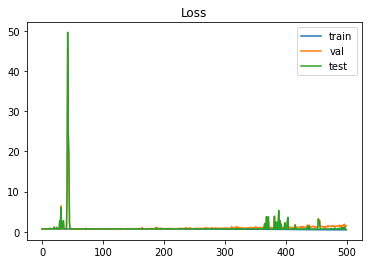

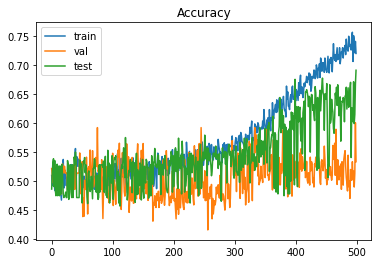

------------fold no---------1----------------------
Total samples in hospital A: 85
Total samples in hospital B: 81
Total samples in hospital C: 124
Total samples in hospital D: 95
Total samples in hospital E: 86
Total samples in hospital F: 546
Epoch 1: TrL=0.7063, TrA=0.4951, VL=0.6962, VA=0.4974, TeL=0.6969, TeA=0.4823, LR=0.00040,
Epoch 2: TrL=0.6970, TrA=0.4902, VL=0.7567, VA=0.5091, TeL=0.7283, TeA=0.4719, LR=0.00040,
Epoch 3: TrL=0.6953, TrA=0.5098, VL=0.7052, VA=0.4974, TeL=0.6979, TeA=0.4750, LR=0.00041,
Epoch 4: TrL=0.6935, TrA=0.5138, VL=0.7002, VA=0.4805, TeL=0.6947, TeA=0.5000, LR=0.00041,
Epoch 5: TrL=0.6927, TrA=0.5039, VL=0.6949, VA=0.5104, TeL=0.6984, TeA=0.4802, LR=0.00042,
Epoch 6: TrL=0.6954, TrA=0.4931, VL=0.6928, VA=0.5247, TeL=0.6971, TeA=0.4688, LR=0.00043,
Epoch 7: TrL=0.6934, TrA=0.5010, VL=0.7044, VA=0.5273, TeL=0.6972, TeA=0.4771, LR=0.00044,
Epoch 8: TrL=0.6915, TrA=0.5049, VL=0.6943, VA=0.5091, TeL=0.6944, TeA=0.5250, LR=0.00045,
Epoch 9: TrL=0.6932, TrA=0

Epoch 88: TrL=0.6878, TrA=0.5266, VL=2.2979, VA=0.5052, TeL=2.4498, TeA=0.4719, LR=0.00526,
Epoch 89: TrL=0.6867, TrA=0.5404, VL=0.7468, VA=0.5182, TeL=0.7146, TeA=0.5385, LR=0.00534,
Epoch 90: TrL=0.6921, TrA=0.5423, VL=0.9206, VA=0.5378, TeL=0.7778, TeA=0.5302, LR=0.00543,
Epoch 91: TrL=0.6927, TrA=0.5226, VL=13.5429, VA=0.5091, TeL=14.6855, TeA=0.4719, LR=0.00552,
Epoch 92: TrL=0.6898, TrA=0.5285, VL=12.7673, VA=0.5091, TeL=13.8675, TeA=0.4719, LR=0.00560,
Epoch 93: TrL=0.6811, TrA=0.5591, VL=8.4001, VA=0.5091, TeL=9.0663, TeA=0.4719, LR=0.00569,
Epoch 94: TrL=0.6836, TrA=0.5512, VL=0.7242, VA=0.5378, TeL=0.7013, TeA=0.5510, LR=0.00577,
Epoch 95: TrL=0.6876, TrA=0.5285, VL=38.5257, VA=0.5091, TeL=41.8450, TeA=0.4719, LR=0.00586,
Epoch 96: TrL=0.6786, TrA=0.5522, VL=0.8236, VA=0.5104, TeL=0.7490, TeA=0.5385, LR=0.00595,
Epoch 97: TrL=0.6792, TrA=0.5453, VL=0.7517, VA=0.5143, TeL=0.7137, TeA=0.5354, LR=0.00603,
Epoch 98: TrL=0.6784, TrA=0.5404, VL=14.3595, VA=0.5091, TeL=15.6021, TeA=

Epoch 176: TrL=0.6704, TrA=0.5640, VL=0.7160, VA=0.5573, TeL=0.6858, TeA=0.5677, LR=0.01000,
Epoch 177: TrL=0.6648, TrA=0.5778, VL=0.7223, VA=0.5417, TeL=0.6751, TeA=0.5813, LR=0.01000,
Epoch 178: TrL=0.6618, TrA=0.5994, VL=22.4532, VA=0.5091, TeL=24.8497, TeA=0.4719, LR=0.01000,
Epoch 179: TrL=0.6667, TrA=0.5571, VL=0.7017, VA=0.5299, TeL=0.6829, TeA=0.5479, LR=0.01000,
Epoch 180: TrL=0.6631, TrA=0.5679, VL=16.1639, VA=0.5091, TeL=17.6224, TeA=0.4719, LR=0.01000,
Epoch 181: TrL=0.6609, TrA=0.5669, VL=0.7159, VA=0.5612, TeL=0.6871, TeA=0.5458, LR=0.00999,
Epoch 182: TrL=0.6627, TrA=0.5512, VL=0.7510, VA=0.5612, TeL=0.6815, TeA=0.5708, LR=0.00999,
Epoch 183: TrL=0.6656, TrA=0.5620, VL=24.1786, VA=0.5091, TeL=26.5222, TeA=0.4719, LR=0.00999,
Epoch 184: TrL=0.6578, TrA=0.5817, VL=0.7858, VA=0.5742, TeL=0.6767, TeA=0.5958, LR=0.00999,
Epoch 185: TrL=0.6563, TrA=0.5679, VL=0.7536, VA=0.5339, TeL=0.6816, TeA=0.5740, LR=0.00998,
Epoch 186: TrL=0.6643, TrA=0.5768, VL=61.4567, VA=0.5091, TeL=67

Epoch 264: TrL=0.5908, TrA=0.6417, VL=3.4037, VA=0.5286, TeL=3.7161, TeA=0.4844, LR=0.00886,
Epoch 265: TrL=0.5704, TrA=0.6575, VL=5.0282, VA=0.4948, TeL=4.6947, TeA=0.5406, LR=0.00884,
Epoch 266: TrL=0.5829, TrA=0.6624, VL=1.1137, VA=0.5378, TeL=0.8192, TeA=0.5865, LR=0.00882,
Epoch 267: TrL=0.5657, TrA=0.6575, VL=3.3237, VA=0.5182, TeL=3.0820, TeA=0.5448, LR=0.00879,
Epoch 268: TrL=0.5633, TrA=0.6644, VL=33.4633, VA=0.5091, TeL=36.5469, TeA=0.4719, LR=0.00877,
Epoch 269: TrL=0.5983, TrA=0.6329, VL=39.4640, VA=0.5130, TeL=44.2117, TeA=0.4750, LR=0.00874,
Epoch 270: TrL=0.5691, TrA=0.6467, VL=34.0102, VA=0.5091, TeL=35.4419, TeA=0.4719, LR=0.00871,
Epoch 271: TrL=0.5800, TrA=0.6319, VL=47.2876, VA=0.5130, TeL=51.8316, TeA=0.4719, LR=0.00869,
Epoch 272: TrL=0.5554, TrA=0.6703, VL=4.9187, VA=0.5026, TeL=4.5291, TeA=0.5448, LR=0.00866,
Epoch 273: TrL=0.5793, TrA=0.6427, VL=4.4426, VA=0.5065, TeL=4.0625, TeA=0.5469, LR=0.00864,
Epoch 274: TrL=0.5759, TrA=0.6486, VL=1.1152, VA=0.5339, TeL=0

Epoch 351: TrL=0.4442, TrA=0.7411, VL=79.3728, VA=0.5091, TeL=86.4245, TeA=0.4719, LR=0.00606,
Epoch 352: TrL=0.4570, TrA=0.7372, VL=22.3165, VA=0.4870, TeL=21.3494, TeA=0.5281, LR=0.00602,
Epoch 353: TrL=0.4831, TrA=0.7274, VL=6.5892, VA=0.5260, TeL=7.0047, TeA=0.5000, LR=0.00599,
Epoch 354: TrL=0.4723, TrA=0.7323, VL=1.1206, VA=0.5560, TeL=0.5975, TeA=0.6448, LR=0.00595,
Epoch 355: TrL=0.4538, TrA=0.7382, VL=80.5937, VA=0.4909, TeL=75.7923, TeA=0.5281, LR=0.00591,
Epoch 356: TrL=0.4708, TrA=0.7372, VL=31.6555, VA=0.4909, TeL=30.0546, TeA=0.5281, LR=0.00587,
Epoch 357: TrL=0.4604, TrA=0.7303, VL=60.9096, VA=0.4909, TeL=58.0607, TeA=0.5281, LR=0.00584,
Epoch 358: TrL=0.4654, TrA=0.7234, VL=45.8336, VA=0.5130, TeL=53.6026, TeA=0.4750, LR=0.00580,
Epoch 359: TrL=0.4413, TrA=0.7480, VL=33.1180, VA=0.4909, TeL=30.9658, TeA=0.5281, LR=0.00576,
Epoch 360: TrL=0.4481, TrA=0.7411, VL=1.4028, VA=0.5378, TeL=0.5990, TeA=0.6510, LR=0.00572,
Epoch 361: TrL=0.4495, TrA=0.7461, VL=3.5170, VA=0.5430,

Epoch 438: TrL=0.3827, TrA=0.7825, VL=18.2285, VA=0.4948, TeL=17.0305, TeA=0.5312, LR=0.00280,
Epoch 439: TrL=0.3726, TrA=0.7953, VL=9.8243, VA=0.5104, TeL=9.0551, TeA=0.5500, LR=0.00277,
Epoch 440: TrL=0.3500, TrA=0.8022, VL=8.5619, VA=0.4909, TeL=7.5345, TeA=0.5563, LR=0.00273,
Epoch 441: TrL=0.3735, TrA=0.7835, VL=2.7086, VA=0.5221, TeL=1.5144, TeA=0.5771, LR=0.00270,
Epoch 442: TrL=0.3812, TrA=0.7854, VL=3.2109, VA=0.5221, TeL=2.1607, TeA=0.5948, LR=0.00266,
Epoch 443: TrL=0.3535, TrA=0.7815, VL=73.4585, VA=0.5091, TeL=79.7509, TeA=0.4719, LR=0.00263,
Epoch 444: TrL=0.3530, TrA=0.7963, VL=20.9758, VA=0.4909, TeL=19.5459, TeA=0.5344, LR=0.00260,
Epoch 445: TrL=0.3798, TrA=0.7864, VL=14.9126, VA=0.4909, TeL=14.0309, TeA=0.5312, LR=0.00256,
Epoch 446: TrL=0.3652, TrA=0.7923, VL=46.8811, VA=0.4909, TeL=43.4117, TeA=0.5281, LR=0.00253,
Epoch 447: TrL=0.3781, TrA=0.7874, VL=2.1205, VA=0.5000, TeL=1.0621, TeA=0.5906, LR=0.00250,
Epoch 448: TrL=0.3626, TrA=0.7874, VL=26.6946, VA=0.4909, Te

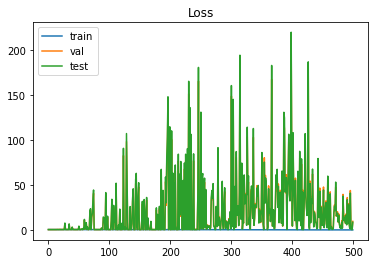

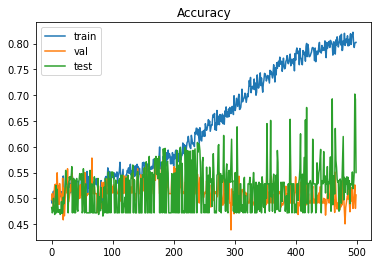

------------fold no---------2----------------------
Total samples in hospital A: 84
Total samples in hospital B: 79
Total samples in hospital C: 127
Total samples in hospital D: 99
Total samples in hospital E: 81
Total samples in hospital F: 547
Epoch 1: TrL=0.7106, TrA=0.4852, VL=0.6939, VA=0.4883, TeL=0.6970, TeA=0.4750, LR=0.00040,
Epoch 2: TrL=0.6934, TrA=0.4941, VL=0.6952, VA=0.5078, TeL=0.6977, TeA=0.5000, LR=0.00040,
Epoch 3: TrL=0.6951, TrA=0.5049, VL=0.6948, VA=0.5013, TeL=0.6982, TeA=0.4885, LR=0.00041,
Epoch 4: TrL=0.6939, TrA=0.5285, VL=0.6862, VA=0.5430, TeL=0.6882, TeA=0.5354, LR=0.00041,
Epoch 5: TrL=0.6936, TrA=0.4980, VL=0.6895, VA=0.5234, TeL=0.6918, TeA=0.5250, LR=0.00042,
Epoch 6: TrL=0.6945, TrA=0.5069, VL=0.6826, VA=0.5469, TeL=0.6900, TeA=0.5385, LR=0.00043,
Epoch 7: TrL=0.6931, TrA=0.5059, VL=0.6881, VA=0.5312, TeL=0.6947, TeA=0.5167, LR=0.00044,
Epoch 8: TrL=0.6930, TrA=0.4931, VL=0.6798, VA=0.5521, TeL=0.7000, TeA=0.4635, LR=0.00045,
Epoch 9: TrL=0.6933, TrA=0

Epoch 88: TrL=0.6941, TrA=0.5000, VL=0.6927, VA=0.5078, TeL=0.6962, TeA=0.4781, LR=0.00526,
Epoch 89: TrL=0.6947, TrA=0.5177, VL=0.8515, VA=0.5117, TeL=0.8493, TeA=0.5281, LR=0.00534,
Epoch 90: TrL=0.6967, TrA=0.5148, VL=0.7716, VA=0.4883, TeL=0.7280, TeA=0.4719, LR=0.00543,
Epoch 91: TrL=0.6968, TrA=0.5020, VL=0.7022, VA=0.4987, TeL=0.6921, TeA=0.4938, LR=0.00552,
Epoch 92: TrL=0.6961, TrA=0.5167, VL=0.6894, VA=0.5169, TeL=0.6934, TeA=0.5052, LR=0.00560,
Epoch 93: TrL=0.6947, TrA=0.4921, VL=0.6909, VA=0.5352, TeL=0.6934, TeA=0.5156, LR=0.00569,
Epoch 94: TrL=0.6952, TrA=0.4882, VL=0.6887, VA=0.5755, TeL=0.6924, TeA=0.5219, LR=0.00577,
Epoch 95: TrL=0.6925, TrA=0.5335, VL=0.6965, VA=0.4883, TeL=0.7005, TeA=0.4719, LR=0.00586,
Epoch 96: TrL=0.6939, TrA=0.5020, VL=0.6919, VA=0.5117, TeL=0.6888, TeA=0.5510, LR=0.00595,
Epoch 97: TrL=0.6947, TrA=0.4872, VL=0.6938, VA=0.5352, TeL=0.6900, TeA=0.5188, LR=0.00603,
Epoch 98: TrL=0.6945, TrA=0.5118, VL=0.6958, VA=0.5182, TeL=0.6935, TeA=0.5156, 

Epoch 177: TrL=0.6853, TrA=0.5600, VL=0.7187, VA=0.5404, TeL=0.7029, TeA=0.5458, LR=0.01000,
Epoch 178: TrL=0.6861, TrA=0.5463, VL=0.7027, VA=0.5273, TeL=0.6901, TeA=0.5615, LR=0.01000,
Epoch 179: TrL=0.6809, TrA=0.5423, VL=0.6934, VA=0.5586, TeL=0.6944, TeA=0.5333, LR=0.01000,
Epoch 180: TrL=0.6807, TrA=0.5581, VL=0.6959, VA=0.5208, TeL=0.6886, TeA=0.5333, LR=0.01000,
Epoch 181: TrL=0.6816, TrA=0.5512, VL=0.6789, VA=0.5495, TeL=0.6840, TeA=0.5510, LR=0.00999,
Epoch 182: TrL=0.6822, TrA=0.5335, VL=0.6755, VA=0.5508, TeL=0.6930, TeA=0.5521, LR=0.00999,
Epoch 183: TrL=0.6777, TrA=0.5482, VL=1.3384, VA=0.4883, TeL=1.4096, TeA=0.4719, LR=0.00999,
Epoch 184: TrL=0.6773, TrA=0.5531, VL=0.6992, VA=0.5729, TeL=0.6933, TeA=0.5656, LR=0.00999,
Epoch 185: TrL=0.6774, TrA=0.5531, VL=0.6837, VA=0.5599, TeL=0.6983, TeA=0.5542, LR=0.00998,
Epoch 186: TrL=0.6792, TrA=0.5472, VL=0.7701, VA=0.4883, TeL=0.7825, TeA=0.4719, LR=0.00998,
Epoch 187: TrL=0.6788, TrA=0.5591, VL=11.8681, VA=0.4883, TeL=12.3276,

Epoch 265: TrL=0.6140, TrA=0.6083, VL=1.5420, VA=0.5117, TeL=1.3123, TeA=0.5375, LR=0.00884,
Epoch 266: TrL=0.6333, TrA=0.5935, VL=1.1147, VA=0.5208, TeL=1.2009, TeA=0.5000, LR=0.00882,
Epoch 267: TrL=0.6335, TrA=0.6102, VL=6.8159, VA=0.5078, TeL=6.4152, TeA=0.5281, LR=0.00879,
Epoch 268: TrL=0.6286, TrA=0.5935, VL=3.4967, VA=0.5078, TeL=3.2356, TeA=0.5312, LR=0.00877,
Epoch 269: TrL=0.6292, TrA=0.6063, VL=3.6264, VA=0.5078, TeL=3.6187, TeA=0.5312, LR=0.00874,
Epoch 270: TrL=0.6354, TrA=0.5984, VL=1.5278, VA=0.4727, TeL=1.2249, TeA=0.5302, LR=0.00871,
Epoch 271: TrL=0.6100, TrA=0.6230, VL=6.1259, VA=0.4883, TeL=6.1681, TeA=0.4719, LR=0.00869,
Epoch 272: TrL=0.6080, TrA=0.6270, VL=3.4567, VA=0.5039, TeL=3.2174, TeA=0.5375, LR=0.00866,
Epoch 273: TrL=0.6250, TrA=0.5797, VL=2.9320, VA=0.4922, TeL=2.6646, TeA=0.4750, LR=0.00864,
Epoch 274: TrL=0.6311, TrA=0.5984, VL=13.4349, VA=0.5117, TeL=12.9976, TeA=0.5281, LR=0.00861,
Epoch 275: TrL=0.6190, TrA=0.6161, VL=12.2217, VA=0.5078, TeL=12.037

Epoch 353: TrL=0.5181, TrA=0.6998, VL=35.4419, VA=0.4883, TeL=37.0951, TeA=0.4719, LR=0.00599,
Epoch 354: TrL=0.5154, TrA=0.7087, VL=9.9038, VA=0.4883, TeL=10.0521, TeA=0.4719, LR=0.00595,
Epoch 355: TrL=0.5135, TrA=0.6781, VL=44.1112, VA=0.4883, TeL=45.7502, TeA=0.4719, LR=0.00591,
Epoch 356: TrL=0.5014, TrA=0.6919, VL=10.9648, VA=0.4883, TeL=10.9303, TeA=0.4719, LR=0.00587,
Epoch 357: TrL=0.5259, TrA=0.6949, VL=6.0594, VA=0.4844, TeL=6.1896, TeA=0.4719, LR=0.00584,
Epoch 358: TrL=0.5194, TrA=0.6978, VL=13.9385, VA=0.4883, TeL=14.3587, TeA=0.4719, LR=0.00580,
Epoch 359: TrL=0.5374, TrA=0.6486, VL=15.0471, VA=0.4883, TeL=16.0313, TeA=0.4719, LR=0.00576,
Epoch 360: TrL=0.5058, TrA=0.6900, VL=18.3765, VA=0.4883, TeL=19.0338, TeA=0.4719, LR=0.00572,
Epoch 361: TrL=0.5049, TrA=0.6841, VL=16.3067, VA=0.4844, TeL=16.5137, TeA=0.4750, LR=0.00568,
Epoch 362: TrL=0.4997, TrA=0.7185, VL=35.1368, VA=0.4883, TeL=36.3692, TeA=0.4719, LR=0.00565,
Epoch 363: TrL=0.4990, TrA=0.7185, VL=29.1427, VA=0.4

Epoch 440: TrL=0.3967, TrA=0.7717, VL=15.2176, VA=0.4883, TeL=16.0862, TeA=0.4719, LR=0.00273,
Epoch 441: TrL=0.4183, TrA=0.7648, VL=19.9972, VA=0.5156, TeL=19.7622, TeA=0.5344, LR=0.00270,
Epoch 442: TrL=0.4076, TrA=0.7352, VL=15.1737, VA=0.4922, TeL=15.7339, TeA=0.4688, LR=0.00266,
Epoch 443: TrL=0.4215, TrA=0.7677, VL=22.3772, VA=0.4883, TeL=22.8296, TeA=0.4719, LR=0.00263,
Epoch 444: TrL=0.3978, TrA=0.7825, VL=17.5641, VA=0.4727, TeL=18.4131, TeA=0.4750, LR=0.00260,
Epoch 445: TrL=0.3876, TrA=0.7697, VL=44.3768, VA=0.4883, TeL=47.0103, TeA=0.4750, LR=0.00256,
Epoch 446: TrL=0.4113, TrA=0.7608, VL=18.1139, VA=0.5195, TeL=16.4624, TeA=0.5312, LR=0.00253,
Epoch 447: TrL=0.3905, TrA=0.7756, VL=14.6406, VA=0.5039, TeL=11.3608, TeA=0.5281, LR=0.00250,
Epoch 448: TrL=0.3911, TrA=0.7815, VL=117.3151, VA=0.5117, TeL=112.6629, TeA=0.5281, LR=0.00246,
Epoch 449: TrL=0.3949, TrA=0.7854, VL=7.6972, VA=0.4961, TeL=7.7164, TeA=0.5000, LR=0.00243,
Epoch 450: TrL=0.4036, TrA=0.7756, VL=85.3251, VA=

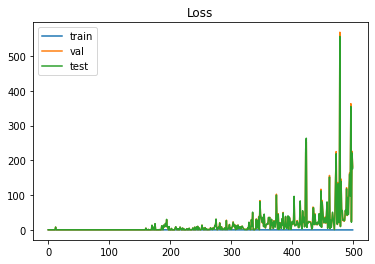

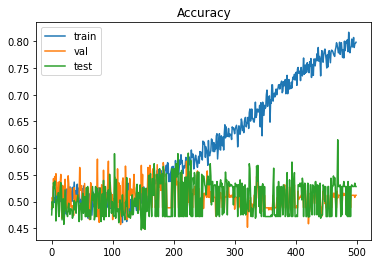

------------fold no---------3----------------------
Total samples in hospital A: 98
Total samples in hospital B: 77
Total samples in hospital C: 100
Total samples in hospital D: 108
Total samples in hospital E: 70
Total samples in hospital F: 564
Epoch 1: TrL=0.7053, TrA=0.5138, VL=0.6902, VA=0.5339, TeL=0.6953, TeA=0.5229, LR=0.00040,
Epoch 2: TrL=0.6969, TrA=0.4911, VL=0.6927, VA=0.5404, TeL=0.6927, TeA=0.5188, LR=0.00040,
Epoch 3: TrL=0.6946, TrA=0.5157, VL=0.6925, VA=0.5430, TeL=0.6961, TeA=0.4781, LR=0.00041,
Epoch 4: TrL=0.6960, TrA=0.4764, VL=0.6918, VA=0.5391, TeL=0.6939, TeA=0.4719, LR=0.00041,
Epoch 5: TrL=0.6964, TrA=0.5197, VL=0.6956, VA=0.4635, TeL=0.6934, TeA=0.4927, LR=0.00042,
Epoch 6: TrL=0.6942, TrA=0.4941, VL=0.7095, VA=0.5195, TeL=0.6956, TeA=0.4844, LR=0.00043,
Epoch 7: TrL=0.6976, TrA=0.4902, VL=0.6947, VA=0.4766, TeL=0.6930, TeA=0.4979, LR=0.00044,
Epoch 8: TrL=0.6961, TrA=0.5030, VL=0.6961, VA=0.4622, TeL=0.6915, TeA=0.5365, LR=0.00045,
Epoch 9: TrL=0.6953, TrA=

Epoch 88: TrL=0.6903, TrA=0.4970, VL=1.0008, VA=0.5391, TeL=0.7674, TeA=0.4719, LR=0.00526,
Epoch 89: TrL=0.6913, TrA=0.5030, VL=1.1072, VA=0.5091, TeL=0.8925, TeA=0.4990, LR=0.00534,
Epoch 90: TrL=0.6906, TrA=0.4921, VL=0.6881, VA=0.5234, TeL=0.6932, TeA=0.4708, LR=0.00543,
Epoch 91: TrL=0.6911, TrA=0.5069, VL=0.7601, VA=0.5312, TeL=0.6942, TeA=0.5240, LR=0.00552,
Epoch 92: TrL=0.6846, TrA=0.5049, VL=0.8576, VA=0.5117, TeL=0.7121, TeA=0.4990, LR=0.00560,
Epoch 93: TrL=0.6939, TrA=0.4970, VL=0.8806, VA=0.5273, TeL=0.7273, TeA=0.4646, LR=0.00569,
Epoch 94: TrL=0.6902, TrA=0.4872, VL=0.7116, VA=0.5156, TeL=0.6957, TeA=0.5083, LR=0.00577,
Epoch 95: TrL=0.6904, TrA=0.5157, VL=0.8102, VA=0.5091, TeL=0.7433, TeA=0.5021, LR=0.00586,
Epoch 96: TrL=0.6908, TrA=0.4862, VL=0.7619, VA=0.5117, TeL=0.6942, TeA=0.4771, LR=0.00595,
Epoch 97: TrL=0.6911, TrA=0.5010, VL=0.7743, VA=0.5234, TeL=0.6961, TeA=0.4927, LR=0.00603,
Epoch 98: TrL=0.6885, TrA=0.5010, VL=0.6883, VA=0.4961, TeL=0.6907, TeA=0.5375, 

Epoch 176: TrL=0.6671, TrA=0.5679, VL=14.9960, VA=0.5195, TeL=16.8538, TeA=0.4750, LR=0.01000,
Epoch 177: TrL=0.6621, TrA=0.5817, VL=32.1915, VA=0.5195, TeL=35.8929, TeA=0.4719, LR=0.01000,
Epoch 178: TrL=0.6724, TrA=0.5630, VL=45.5987, VA=0.5195, TeL=51.2152, TeA=0.4719, LR=0.01000,
Epoch 179: TrL=0.6576, TrA=0.5876, VL=0.8044, VA=0.5052, TeL=0.7096, TeA=0.5542, LR=0.01000,
Epoch 180: TrL=0.6748, TrA=0.5650, VL=17.2883, VA=0.5234, TeL=19.4713, TeA=0.4719, LR=0.01000,
Epoch 181: TrL=0.6698, TrA=0.5620, VL=29.1159, VA=0.5195, TeL=32.4979, TeA=0.4719, LR=0.00999,
Epoch 182: TrL=0.6610, TrA=0.5709, VL=0.8447, VA=0.5052, TeL=0.7116, TeA=0.5635, LR=0.00999,
Epoch 183: TrL=0.6702, TrA=0.5610, VL=0.7847, VA=0.4974, TeL=0.7062, TeA=0.5448, LR=0.00999,
Epoch 184: TrL=0.6628, TrA=0.5778, VL=0.8245, VA=0.5586, TeL=0.7144, TeA=0.5552, LR=0.00999,
Epoch 185: TrL=0.6756, TrA=0.5748, VL=0.7983, VA=0.5247, TeL=0.7054, TeA=0.5510, LR=0.00998,
Epoch 186: TrL=0.6598, TrA=0.5984, VL=22.8386, VA=0.5234, Te

Epoch 264: TrL=0.6307, TrA=0.6063, VL=75.7717, VA=0.5195, TeL=84.2167, TeA=0.4719, LR=0.00886,
Epoch 265: TrL=0.6394, TrA=0.5886, VL=0.7682, VA=0.5169, TeL=0.6786, TeA=0.5823, LR=0.00884,
Epoch 266: TrL=0.6174, TrA=0.6132, VL=35.6117, VA=0.5195, TeL=39.8978, TeA=0.4719, LR=0.00882,
Epoch 267: TrL=0.6256, TrA=0.6083, VL=0.8872, VA=0.5052, TeL=0.6971, TeA=0.5865, LR=0.00879,
Epoch 268: TrL=0.6225, TrA=0.6033, VL=29.2457, VA=0.5195, TeL=32.3224, TeA=0.4719, LR=0.00877,
Epoch 269: TrL=0.6224, TrA=0.6073, VL=0.9781, VA=0.5091, TeL=0.7486, TeA=0.5771, LR=0.00874,
Epoch 270: TrL=0.6336, TrA=0.6043, VL=0.9723, VA=0.5013, TeL=0.7176, TeA=0.5802, LR=0.00871,
Epoch 271: TrL=0.6195, TrA=0.6240, VL=0.8994, VA=0.5052, TeL=0.6942, TeA=0.5771, LR=0.00869,
Epoch 272: TrL=0.6279, TrA=0.6181, VL=64.1058, VA=0.5195, TeL=71.4191, TeA=0.4719, LR=0.00866,
Epoch 273: TrL=0.6147, TrA=0.6230, VL=35.5860, VA=0.5234, TeL=39.7349, TeA=0.4719, LR=0.00864,
Epoch 274: TrL=0.6230, TrA=0.6152, VL=44.1838, VA=0.5195, Te

Epoch 352: TrL=0.5819, TrA=0.6575, VL=4.4805, VA=0.4805, TeL=3.9977, TeA=0.5406, LR=0.00602,
Epoch 353: TrL=0.5590, TrA=0.6526, VL=20.3909, VA=0.5195, TeL=22.2165, TeA=0.4750, LR=0.00599,
Epoch 354: TrL=0.5615, TrA=0.6417, VL=1.2453, VA=0.5365, TeL=0.8455, TeA=0.5698, LR=0.00595,
Epoch 355: TrL=0.5646, TrA=0.6604, VL=19.2236, VA=0.5234, TeL=21.6100, TeA=0.4750, LR=0.00591,
Epoch 356: TrL=0.5561, TrA=0.6545, VL=1.5955, VA=0.5039, TeL=0.8251, TeA=0.6302, LR=0.00587,
Epoch 357: TrL=0.5584, TrA=0.6545, VL=14.7072, VA=0.5273, TeL=16.2564, TeA=0.4750, LR=0.00584,
Epoch 358: TrL=0.5613, TrA=0.6624, VL=1.2968, VA=0.5273, TeL=0.9975, TeA=0.4990, LR=0.00580,
Epoch 359: TrL=0.5650, TrA=0.6565, VL=1.9373, VA=0.5052, TeL=1.6285, TeA=0.5479, LR=0.00576,
Epoch 360: TrL=0.5653, TrA=0.6467, VL=3.7114, VA=0.5000, TeL=3.0730, TeA=0.5375, LR=0.00572,
Epoch 361: TrL=0.5733, TrA=0.6506, VL=5.8955, VA=0.4883, TeL=5.4796, TeA=0.5344, LR=0.00568,
Epoch 362: TrL=0.5602, TrA=0.6486, VL=9.9886, VA=0.4896, TeL=9.0

Epoch 440: TrL=0.4995, TrA=0.6969, VL=3.0639, VA=0.5208, TeL=0.8152, TeA=0.6167, LR=0.00273,
Epoch 441: TrL=0.4873, TrA=0.7047, VL=89.7904, VA=0.5195, TeL=98.4652, TeA=0.4719, LR=0.00270,
Epoch 442: TrL=0.4880, TrA=0.6870, VL=99.3372, VA=0.5195, TeL=107.9598, TeA=0.4719, LR=0.00266,
Epoch 443: TrL=0.5069, TrA=0.6988, VL=3.6807, VA=0.5013, TeL=1.1892, TeA=0.5479, LR=0.00263,
Epoch 444: TrL=0.4884, TrA=0.7047, VL=2.4377, VA=0.5469, TeL=0.9891, TeA=0.5146, LR=0.00260,
Epoch 445: TrL=0.5028, TrA=0.7008, VL=63.2313, VA=0.5195, TeL=70.4479, TeA=0.4719, LR=0.00256,
Epoch 446: TrL=0.4918, TrA=0.7067, VL=2.5584, VA=0.5013, TeL=1.3520, TeA=0.5375, LR=0.00253,
Epoch 447: TrL=0.4938, TrA=0.6949, VL=77.7993, VA=0.5195, TeL=86.0670, TeA=0.4719, LR=0.00250,
Epoch 448: TrL=0.4851, TrA=0.6998, VL=3.5309, VA=0.5312, TeL=1.6561, TeA=0.5271, LR=0.00246,
Epoch 449: TrL=0.4671, TrA=0.7175, VL=2.6117, VA=0.4909, TeL=1.0547, TeA=0.5500, LR=0.00243,
Epoch 450: TrL=0.4827, TrA=0.6978, VL=2.7125, VA=0.5182, TeL=

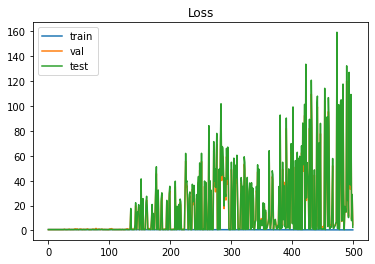

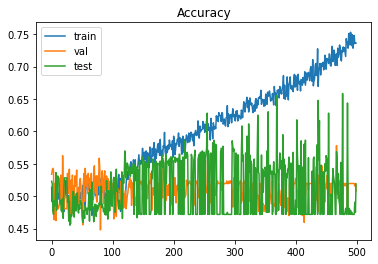

------------fold no---------4----------------------
Total samples in hospital A: 114
Total samples in hospital B: 103
Total samples in hospital C: 133
Total samples in hospital D: 139
Total samples in hospital E: 101
Total samples in hospital F: 427
Epoch 1: TrL=0.7021, TrA=0.5059, VL=0.6930, VA=0.4870, TeL=0.6928, TeA=0.5156, LR=0.00040,
Epoch 2: TrL=0.6936, TrA=0.5128, VL=0.6919, VA=0.5378, TeL=0.6911, TeA=0.5479, LR=0.00040,
Epoch 3: TrL=0.6953, TrA=0.5010, VL=0.6942, VA=0.4570, TeL=0.6933, TeA=0.4948, LR=0.00041,
Epoch 4: TrL=0.6929, TrA=0.5315, VL=0.6912, VA=0.5326, TeL=0.6921, TeA=0.5156, LR=0.00041,
Epoch 5: TrL=0.6923, TrA=0.5364, VL=0.9180, VA=0.4648, TeL=0.9172, TeA=0.4719, LR=0.00042,
Epoch 6: TrL=0.6913, TrA=0.5226, VL=0.6962, VA=0.4648, TeL=0.7039, TeA=0.4719, LR=0.00043,
Epoch 7: TrL=0.6944, TrA=0.5049, VL=0.7193, VA=0.4648, TeL=0.7190, TeA=0.4719, LR=0.00044,
Epoch 8: TrL=0.6883, TrA=0.5364, VL=0.6952, VA=0.4570, TeL=0.6938, TeA=0.5042, LR=0.00045,
Epoch 9: TrL=0.6881, T

Epoch 88: TrL=0.6825, TrA=0.5443, VL=25.9956, VA=0.4648, TeL=25.4677, TeA=0.4719, LR=0.00526,
Epoch 89: TrL=0.6840, TrA=0.5394, VL=0.6897, VA=0.5469, TeL=0.6870, TeA=0.5417, LR=0.00534,
Epoch 90: TrL=0.6822, TrA=0.5423, VL=89.5830, VA=0.4648, TeL=87.5557, TeA=0.4719, LR=0.00543,
Epoch 91: TrL=0.6862, TrA=0.5433, VL=0.6962, VA=0.5430, TeL=0.6887, TeA=0.5448, LR=0.00552,
Epoch 92: TrL=0.6796, TrA=0.5354, VL=53.3052, VA=0.4648, TeL=52.0866, TeA=0.4719, LR=0.00560,
Epoch 93: TrL=0.6802, TrA=0.5531, VL=0.7057, VA=0.5391, TeL=0.7001, TeA=0.5354, LR=0.00569,
Epoch 94: TrL=0.6767, TrA=0.5591, VL=8.6167, VA=0.4648, TeL=8.4823, TeA=0.4719, LR=0.00577,
Epoch 95: TrL=0.6809, TrA=0.5344, VL=0.6974, VA=0.4727, TeL=0.6964, TeA=0.5635, LR=0.00586,
Epoch 96: TrL=0.6903, TrA=0.5157, VL=0.8015, VA=0.4648, TeL=0.7847, TeA=0.4750, LR=0.00595,
Epoch 97: TrL=0.6885, TrA=0.5236, VL=0.6952, VA=0.4479, TeL=0.6995, TeA=0.4625, LR=0.00603,
Epoch 98: TrL=0.6832, TrA=0.5305, VL=11.7191, VA=0.4648, TeL=11.4828, TeA=

Epoch 176: TrL=0.6658, TrA=0.5728, VL=18.1473, VA=0.4648, TeL=17.6936, TeA=0.4719, LR=0.01000,
Epoch 177: TrL=0.6611, TrA=0.5778, VL=13.0673, VA=0.4648, TeL=12.7245, TeA=0.4719, LR=0.01000,
Epoch 178: TrL=0.6629, TrA=0.5650, VL=15.8075, VA=0.4648, TeL=15.3942, TeA=0.4719, LR=0.01000,
Epoch 179: TrL=0.6710, TrA=0.5778, VL=29.2300, VA=0.4648, TeL=28.4712, TeA=0.4719, LR=0.01000,
Epoch 180: TrL=0.6722, TrA=0.5522, VL=14.3599, VA=0.4648, TeL=14.0007, TeA=0.4719, LR=0.01000,
Epoch 181: TrL=0.6666, TrA=0.5640, VL=11.4174, VA=0.4648, TeL=11.1101, TeA=0.4719, LR=0.00999,
Epoch 182: TrL=0.6614, TrA=0.5728, VL=0.9847, VA=0.4648, TeL=0.9694, TeA=0.4781, LR=0.00999,
Epoch 183: TrL=0.6660, TrA=0.5886, VL=0.7370, VA=0.5391, TeL=0.7547, TeA=0.5375, LR=0.00999,
Epoch 184: TrL=0.6585, TrA=0.5630, VL=27.0292, VA=0.4648, TeL=26.3236, TeA=0.4719, LR=0.00999,
Epoch 185: TrL=0.6642, TrA=0.5768, VL=20.0762, VA=0.4648, TeL=19.5971, TeA=0.4719, LR=0.00998,
Epoch 186: TrL=0.6642, TrA=0.5945, VL=23.8657, VA=0.46

Epoch 263: TrL=0.5945, TrA=0.6240, VL=8.4043, VA=0.4648, TeL=8.0227, TeA=0.4750, LR=0.00889,
Epoch 264: TrL=0.5892, TrA=0.6270, VL=11.2574, VA=0.4648, TeL=10.5902, TeA=0.4781, LR=0.00886,
Epoch 265: TrL=0.6036, TrA=0.6289, VL=15.8857, VA=0.5352, TeL=15.9172, TeA=0.5281, LR=0.00884,
Epoch 266: TrL=0.5966, TrA=0.6201, VL=17.7355, VA=0.5312, TeL=17.6404, TeA=0.5281, LR=0.00882,
Epoch 267: TrL=0.5884, TrA=0.6427, VL=1.7338, VA=0.4609, TeL=1.4052, TeA=0.5125, LR=0.00879,
Epoch 268: TrL=0.5906, TrA=0.6398, VL=2.3411, VA=0.5312, TeL=2.3730, TeA=0.5344, LR=0.00877,
Epoch 269: TrL=0.5829, TrA=0.6555, VL=2.3987, VA=0.5312, TeL=2.4436, TeA=0.5385, LR=0.00874,
Epoch 270: TrL=0.5840, TrA=0.6486, VL=122.7351, VA=0.4648, TeL=119.1564, TeA=0.4719, LR=0.00871,
Epoch 271: TrL=0.5929, TrA=0.6496, VL=81.1957, VA=0.4648, TeL=78.2364, TeA=0.4719, LR=0.00869,
Epoch 272: TrL=0.5719, TrA=0.6457, VL=117.6157, VA=0.4648, TeL=114.2615, TeA=0.4719, LR=0.00866,
Epoch 273: TrL=0.5795, TrA=0.6368, VL=135.6937, VA=0.4

Epoch 350: TrL=0.4867, TrA=0.6998, VL=3.6740, VA=0.5065, TeL=2.8532, TeA=0.5563, LR=0.00610,
Epoch 351: TrL=0.4732, TrA=0.7352, VL=3.2393, VA=0.5352, TeL=3.1347, TeA=0.5312, LR=0.00606,
Epoch 352: TrL=0.4862, TrA=0.7165, VL=2.0635, VA=0.5391, TeL=1.9408, TeA=0.5521, LR=0.00602,
Epoch 353: TrL=0.4812, TrA=0.7096, VL=8.5994, VA=0.5352, TeL=8.8754, TeA=0.5281, LR=0.00599,
Epoch 354: TrL=0.4916, TrA=0.7126, VL=196.5461, VA=0.4648, TeL=190.5432, TeA=0.4719, LR=0.00595,
Epoch 355: TrL=0.4878, TrA=0.7215, VL=15.0255, VA=0.5352, TeL=15.1208, TeA=0.5281, LR=0.00591,
Epoch 356: TrL=0.4845, TrA=0.7313, VL=142.2192, VA=0.4648, TeL=138.2332, TeA=0.4719, LR=0.00587,
Epoch 357: TrL=0.4716, TrA=0.7205, VL=138.9522, VA=0.4648, TeL=134.1491, TeA=0.4719, LR=0.00584,
Epoch 358: TrL=0.4884, TrA=0.7175, VL=282.7356, VA=0.4648, TeL=274.3210, TeA=0.4719, LR=0.00580,
Epoch 359: TrL=0.4966, TrA=0.7096, VL=266.9384, VA=0.4648, TeL=259.4763, TeA=0.4719, LR=0.00576,
Epoch 360: TrL=0.4782, TrA=0.7333, VL=186.6810, 

Epoch 436: TrL=0.4126, TrA=0.7530, VL=29.1496, VA=0.5352, TeL=28.8875, TeA=0.5281, LR=0.00287,
Epoch 437: TrL=0.4392, TrA=0.7549, VL=300.6188, VA=0.4648, TeL=291.6189, TeA=0.4719, LR=0.00284,
Epoch 438: TrL=0.4048, TrA=0.7638, VL=575.4149, VA=0.5352, TeL=575.4622, TeA=0.5281, LR=0.00280,
Epoch 439: TrL=0.3895, TrA=0.7815, VL=142.0206, VA=0.5352, TeL=141.8352, TeA=0.5281, LR=0.00277,
Epoch 440: TrL=0.4379, TrA=0.7510, VL=3.2263, VA=0.4727, TeL=3.2573, TeA=0.4844, LR=0.00273,
Epoch 441: TrL=0.4200, TrA=0.7697, VL=311.1787, VA=0.4648, TeL=302.5614, TeA=0.4719, LR=0.00270,
Epoch 442: TrL=0.4297, TrA=0.7608, VL=51.6122, VA=0.5352, TeL=51.1681, TeA=0.5281, LR=0.00266,
Epoch 443: TrL=0.4025, TrA=0.7638, VL=2.2139, VA=0.5352, TeL=1.7014, TeA=0.5687, LR=0.00263,
Epoch 444: TrL=0.4115, TrA=0.7677, VL=2.3192, VA=0.5273, TeL=1.5455, TeA=0.6094, LR=0.00260,
Epoch 445: TrL=0.4103, TrA=0.7569, VL=375.4920, VA=0.5352, TeL=376.1742, TeA=0.5281, LR=0.00256,
Epoch 446: TrL=0.3995, TrA=0.7766, VL=2.2462, 

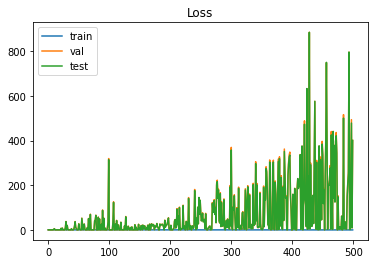

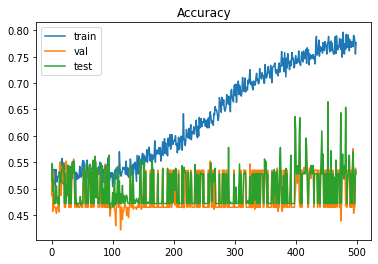

In [27]:
skf = StratifiedKFold(n_splits=5)
epochs=500
for fold,(train_idx, val_idx) in enumerate(skf.split(train_val, tv_labels)):
    writer = SummaryWriter("runs/STRATIFIED IMG-ONLY", filename_suffix=f"_F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))   
    train_df = df.iloc[train_idx]
    train_set = ImageDataset(indices=train_df, image_dir=f"{data_path}DATASET", transform=my_transform)

    val_df = df.iloc[val_idx]
    val_set = ImageDataset(indices=val_df, image_dir=f"{data_path}DATASET", transform=my_transform)
    
    print("Total samples in hospital A:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==1]))
    print("Total samples in hospital B:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==2]))
    print("Total samples in hospital C:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==3]))
    print("Total samples in hospital D:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==4]))
    print("Total samples in hospital E:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==5]))
    print("Total samples in hospital F:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==6]))
    
    train_loader = DataLoader(train_set, batch_size=8, num_workers=2, drop_last=True, shuffle=True, generator=generator)
    val_loader   = DataLoader(val_set,   batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Define an optimizier
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)
    
    
    #model, optimizer = ipex.optimize(model, optimizer=optimizer,dtype=torch.double)
    #model = model.float()
    # Train model
    train(model, loaders, optimizer, criterion, epochs=500, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)